In [2]:
## Importar librerias necesarias
import numpy as np
import matplotlib.pyplot as plt
import duckdb

duckdb.read_parquet("""datos_urgencia_consolidados.parquet""")

def find_peak_week(df, column,window = 5):
    if window % 2 == 0:
        print("please chooose an odd length window")
        return
    n = df.shape[0]
    compare = df[column].drop([k for k in range(window)]).reset_index(drop= True) - df[column].drop([n-window + k for k in range(window)]).reset_index(drop= True)
    compare= compare.reset_index(drop= True)
    return np.argmax(compare)+window //2 

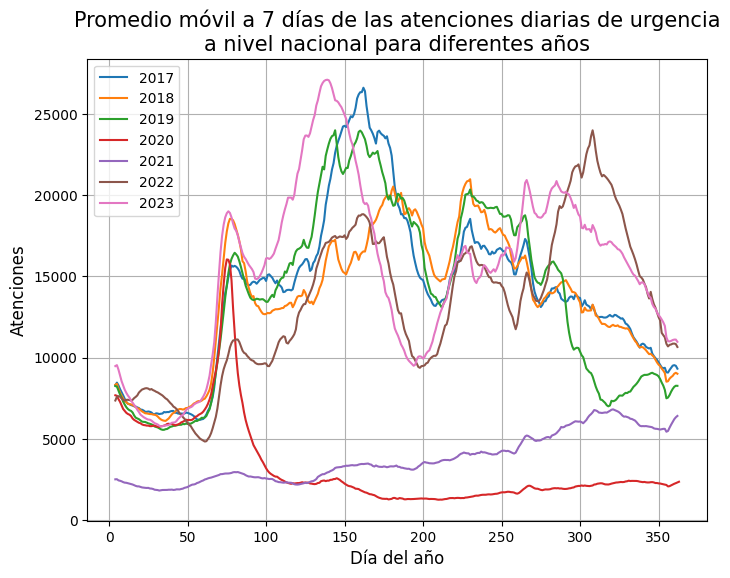

In [5]:
#Full average: Goal to compare populations across years, 
#ages and locations by trying to stablish a baseline reference demand.
#This tries to improve agains using the mean
df3 = duckdb.sql("""
select 
      year(strptime(fecha, '%d/%m/%Y')) as year
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , sum(Menores_1) as Menores_1
    , sum(De_1_a_4) as De_1_a_4
    , sum(De_5_a_14) as De_5_a_14
    , sum(De_15_a_64) as De_15_a_64
    , sum(De_65_y_mas) as De_65_y_mas
    , sum(Menores_1) + sum(De_1_a_4)+ sum(De_5_a_14) + sum(De_15_a_64) + sum(De_65_y_mas) as atenciones
FROM datos_urgencia_consolidados.parquet
where IdCausa in (3,4,5,6,10,11) 
--and dayofyear(strptime(fecha, '%d/%m/%Y')) <=365
--and year(strptime(fecha, '%d/%m/%Y')) in (2017,2018,2019,2022,2023)
group by year, nrodia
order by year, nrodia
""").df()
df_dict = {key[0]: d for key, d in df3[['year','nrodia','atenciones']].groupby(['year'])}

# ILUSTRACIÓN 1 ATENCIONES DIARIAS DE URGENCIA PARA CADA DÍA DEL AÑO CORRESPONDIENTES AL PERIODO 2017 -2023 
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1) 
targets = list(df_dict.keys())
ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
for key in targets:
    plt.plot(df_dict[key]['nrodia'],df_dict[key]['atenciones'].rolling(7,center=True).mean() )
plt.legend(targets)
ax.grid()
ax.set_title('Promedio móvil a 7 días de las atenciones diarias de urgencia\na nivel nacional para diferentes años', fontsize = 15)
ax.set_xlabel('Día del año', fontsize = 12)
ax.set_ylabel('Atenciones', fontsize = 12)

plt.savefig('fig1_atenciones_urgencia_diarias.png', bbox_inches='tight')